# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

# Data

In [3]:
df = pd.read_csv('data/logs_all.csv')

In [4]:
info = ["Name"]
features = ["Min", "Gls", "Sh", "SoT", "xG", "npxG", "xAG", "CS", "Was Home"]
to_predict = ["FPL"]

In [5]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

In [6]:
df

,Name,Min,Gls,Sh,SoT,xG,npxG,xAG,CS,Was Home,FPL
0,Miguel-Almiron,83.0,0.0,3.0,0.0,0.2,0.2,0.0,0.0,0.0,2.0
1,Miguel-Almiron,83.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,Miguel-Almiron,69.0,0.0,3.0,0.0,0.2,0.2,0.1,1.0,1.0,3.0
3,Miguel-Almiron,88.0,0.0,2.0,1.0,0.2,0.2,0.1,0.0,1.0,2.0
4,Miguel-Almiron,90.0,2.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...
100,Wilfried-Zaha,90.0,1.0,4.0,2.0,0.3,0.3,0.1,0.0,0.0,10.0
101,Wilfried-Zaha,90.0,0.0,2.0,0.0,0.9,0.1,0.1,0.0,0.0,2.0
102,Wilfried-Zaha,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
103,Wilfried-Zaha,90.0,0.0,1.0,0.0,0.1,0.1,0.6,1.0,0.0,3.0


In [7]:
for p in df["Name"].unique():
    print (p, df[df["Name"] == p].shape)

Miguel-Almiron (15, 11)
Kevin-De-Bruyne (15, 11)
Bruno-Fernandes (15, 11)
Mason-Mount (15, 11)
Bukayo-Saka (15, 11)
Mohamed-Salah (15, 11)
Wilfried-Zaha (15, 11)


In [8]:
# shifting
# df['FPL'] = df['FPL'].shift(-1)
# test_row = df[-1]
# df = df[:-1]

# DF to DataLoader

In [9]:
from torchvision.transforms import ToTensor

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        # print(idx)
        name = self.names[idx]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name].drop(columns=["Name"]).values[:, :-1]
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        target = target.astype(np.float32)
        target = torch.from_numpy(target)
        # print(type(target))
        return features, target

In [10]:
dataset = PandasDataset(df)
# dataset.__getitem__(3)

(array([[90. ,  0. ,  2. ,  0. ,  0.2,  0.2,  0.1,  0. ,  1. ],
        [76. ,  0. ,  3. ,  1. ,  0.3,  0.3,  0.3,  0. ,  0. ],
        [45. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0.3,  0. ,  0. ],
        [31. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [83. ,  0. ,  3. ,  0. ,  0.2,  0.2,  0.1,  0. ,  0. ],
        [71. ,  0. ,  3. ,  0. ,  0.1,  0.1,  0.5,  1. ,  1. ],
        [90. ,  2. ,  3. ,  2. ,  0.4,  0.4,  0. ,  1. ,  0. ],
        [61. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
        [90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0. ,  1. ],
        [90. ,  0. ,  3. ,  2. ,  0.1,  0.1,  0. ,  0. ,  0. ],
        [77. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0.1,  0. ,  1. ],
        [72. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [90. ,  1. ,  2. ,  2. ,  0.1,  0.1,  0.3,  1. ,  1. ],
        [72. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0. ,  0. ,  0. ]],
       dtype=float32),
 tensor([ 2.,  2

In [11]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [12]:
# next(iter(dataloader))

[tensor([[[87.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.2000,
            1.0000,  0.0000],
          [90.0000,  0.0000,  2.0000,  1.0000,  0.5000,  0.5000,  0.2000,
            0.0000,  1.0000],
          [87.0000,  0.0000,  3.0000,  0.0000,  0.5000,  0.5000,  0.3000,
            0.0000,  1.0000],
          [90.0000,  1.0000,  4.0000,  1.0000,  0.4000,  0.4000,  0.0000,
            0.0000,  0.0000],
          [89.0000,  0.0000,  3.0000,  1.0000,  0.2000,  0.2000,  0.3000,
            1.0000,  0.0000],
          [90.0000,  0.0000,  3.0000,  1.0000,  0.3000,  0.3000,  0.3000,
            0.0000,  1.0000],
          [89.0000,  2.0000,  3.0000,  2.0000,  1.9000,  1.3000,  0.0000,
            0.0000,  1.0000],
          [81.0000,  1.0000,  1.0000,  1.0000,  0.1000,  0.1000,  0.1000,
            1.0000,  0.0000],
          [90.0000,  0.0000,  2.0000,  0.0000,  0.1000,  0.1000,  0.0000,
            0.0000,  0.0000],
          [26.0000,  0.0000,  1.0000,  0.0000,  0.2000,  0.2000,

# LSTM Model

In [13]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[-1])
        return out

In [14]:
net = LSTMNetwork(9, 20, 2, 1, dropout=0.2)

# Training loop

In [15]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [16]:
num_epochs = 1000
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        # print(inputs.shape)
        # print(targets.shape)
        # print(targets)
        optimizer.zero_grad()
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    loss_history.append(running_loss / len(dataloader))
    if epoch % 50 == 0:
        print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')

C:\users\user\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 30.94594464983259
Epoch 50 Loss: 8.972484384264265
Epoch 100 Loss: 8.971795763288226
Epoch 150 Loss: 8.95136819566999
Epoch 200 Loss: 8.929878779820033
Epoch 250 Loss: 8.919289657047816
Epoch 300 Loss: 8.89469303403582
Epoch 350 Loss: 8.898208277566093
Epoch 400 Loss: 8.864506380898613
Epoch 450 Loss: 8.916294642857142
Epoch 500 Loss: 8.915608610425677
Epoch 550 Loss: 8.905636378696986
Epoch 600 Loss: 8.862186636243548
Epoch 650 Loss: 8.895719868796212
Epoch 700 Loss: 8.869763919285365
Epoch 750 Loss: 8.87104538508824
Epoch 800 Loss: 8.822807516370501
Epoch 850 Loss: 8.846661499568395
Epoch 900 Loss: 8.847080162593297
Epoch 950 Loss: 8.813506262642997


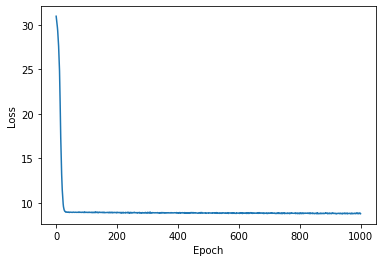

In [17]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()